# Recommender system for Anime

# Import Library

Melakukan import library yang digunakan untuk melakukan manipulasi data dan modelling content-based filtering dan collaborative filtering dalam membuat sistem rekomendasi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import  EarlyStopping

# Data Loading

Melakukan loading dataset untuk membuat sistem rekomendasi dari kaggle. dataset dapat diakses melalui [di sini](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download CooperUnion/anime-recommendations-database

In [3]:
!unzip /content/anime-recommendations-database.zip -d /content/

Archive:  /content/anime-recommendations-database.zip
  inflating: /content/anime.csv      
  inflating: /content/rating.csv     


In [2]:
anime = pd.read_csv('content/anime.csv')
print('Jumlah data judul anime: ', len(anime.anime_id.unique()))
anime

Jumlah data judul anime:  12294


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [3]:
rating = pd.read_csv('content/rating.csv')
print('Jumlah data rating: ', len(rating.user_id.unique()))
rating

Jumlah data rating:  73515


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


# Data Understanding

## File anime.csv

In [6]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [7]:
print('Banyak Judul Anime: ', len(anime.anime_id.unique()))
print('Genre Anime: ', anime.genre.unique())

Banyak Judul Anime:  12294
Genre Anime:  ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


Terdapat 12294 judul anime yang terdapat pada dataset

In [10]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Rata-rata rating anime yang diberikan user berkisar antara 1.67 sampai 10

## File rating.csv

In [11]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [12]:
print('Banyak user yang memberikan rating: ', len(rating.user_id.unique()))
print('Id Anime: ', rating.anime_id.unique())

Banyak user yang memberikan rating:  73515
Id Anime:  [   20    24    79 ... 29481 34412 30738]


In [13]:
print(rating.shape)

(7813737, 3)


In [14]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Terdapat noise dalam data pada kolom rating, dimana terdapat rating dari user bernilai -1. data ini nanti akan dihapus

In [17]:
print('Jumlah anime yang dirating: ', len(rating.anime_id.unique()))
print('Jumlah data rating: ', len(rating))

Jumlah anime yang dirating:  11200
Jumlah data rating:  7813737


Ternyata tidak semua anime yang berada pada database anime diberikan rating oleh user

<Axes: xlabel='type', ylabel='count'>

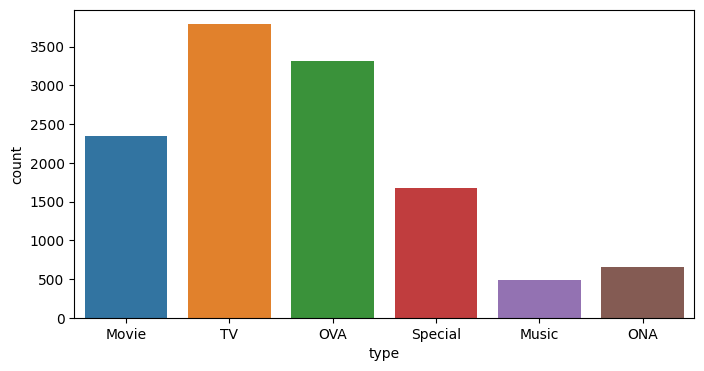

In [29]:
# Visualisasi untuk kolom type pada dataset anime
plt.figure(figsize=(8,4))
sns.countplot(x=anime["type"])

Pada visualisasi diatas, type anime terbanyak adalah TV

<Axes: xlabel='rating', ylabel='count'>

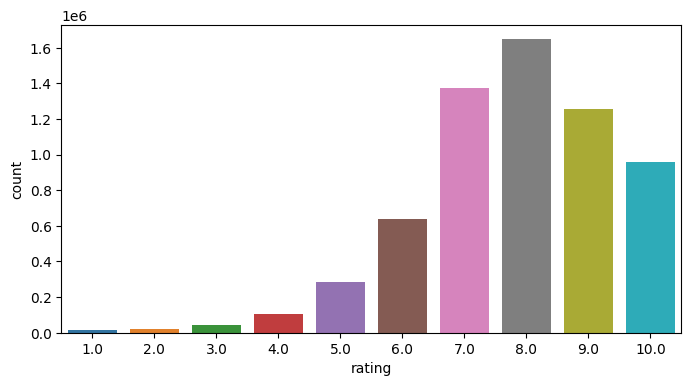

In [38]:
# Visualisasi untuk rating oleh user
# rating_viz = rating["rating"].replace({-1: np.nan}, inplace=True)
# rating_viz = rating.dropna(axis = 0, how ='any')
plt.figure(figsize=(8,4))
sns.countplot(x=rating_viz["rating"])

Rating terbanyak yang diberikan adalah 8

# Data Preparation

Selanjutnya menggabungkan anime dan rating dengan menggunakan anime_id

### Content-based filtering

In [4]:
anime_all = pd.merge(anime, rating, on='anime_id', suffixes=['', '_user'])
anime_all

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1
...,...,...,...,...,...,...,...,...,...
7813722,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532,-1
7813723,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766,-1
7813724,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4
7813725,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364,-1


Mengisi kolom genre, type, dan rating yang null agar informasi penting lainnya tidak hilang

In [5]:
ratingsMean = anime.rating.mean()
anime_all["rating_user"].replace({-1: np.nan}, inplace=True)
anime_all['genre'] = anime_all['genre'].fillna('TBD')
anime_all['type'] = anime_all['type'].fillna('TBD')
anime_all['rating'] = anime_all['rating'].fillna(ratingsMean)

In [6]:
anime_all.isnull().sum()

anime_id             0
name                 0
genre                0
type                 0
episodes             0
rating               0
members              0
user_id              0
rating_user    1476488
dtype: int64

Menghapus rating user yang bernilai -1

In [7]:
anime_all = anime_all.dropna(axis = 0, how ='any')
anime_all.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
rating_user    0
dtype: int64

## Collaborative Filtering

Memilih data anime dengan penggemar lebih dari 250000 agar pengguna direkomendasikan anime yang cukup terkenal

In [8]:
anime250k = anime_all[anime_all.members > 250000]
anime250k

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2199,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3,10.0
2200,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,10,10.0
2201,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,11,8.0
2202,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,12,9.0
2203,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,17,10.0
...,...,...,...,...,...,...,...,...,...
7563498,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73473,5.0
7563499,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73476,4.0
7563501,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73478,6.0
7563502,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73481,9.0


In [10]:
anime_fix = anime250k
anime_fix.sort_values('members')

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2452310,7724,Shiki,"Mystery, Supernatural, Thriller, Vampire",TV,22,7.99,251093,16665,9.0
2451298,7724,Shiki,"Mystery, Supernatural, Thriller, Vampire",TV,22,7.99,251093,6106,8.0
2451296,7724,Shiki,"Mystery, Supernatural, Thriller, Vampire",TV,22,7.99,251093,6100,5.0
2451294,7724,Shiki,"Mystery, Supernatural, Thriller, Vampire",TV,22,7.99,251093,6089,8.0
2451293,7724,Shiki,"Mystery, Supernatural, Thriller, Vampire",TV,22,7.99,251093,6080,7.0
...,...,...,...,...,...,...,...,...,...
360083,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,29297,9.0
360084,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,29299,10.0
360085,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,29300,9.0
360087,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,29304,7.0


Selanjutnya akan dilakukan konversi data dari data series menjadi list dan akan dilakukan encode pada kolom user_id dan anime_id dan akan dilakukan mapping terhadap dua kolom tersebut

In [11]:
# Mengubah user_id menjadi list
user_id = anime_fix['user_id'].unique().tolist()
print('list user_id: ', user_id)

# Encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
print('encoded user_id : ', user_to_user_encoded)

# Encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}

print('encoded angka ke user_id: ', user_encoded_to_user)

list user_id:  [3, 10, 11, 12, 17, 19, 21, 30, 38, 39, 43, 44, 45, 46, 50, 51, 57, 60, 66, 68, 72, 73, 77, 79, 80, 81, 82, 84, 87, 95, 97, 99, 104, 105, 110, 117, 118, 124, 128, 129, 137, 139, 140, 142, 144, 148, 150, 152, 153, 159, 163, 165, 166, 171, 173, 176, 177, 179, 180, 181, 183, 190, 191, 194, 197, 203, 206, 209, 210, 220, 226, 228, 231, 235, 238, 241, 243, 244, 247, 248, 249, 250, 252, 253, 261, 266, 268, 269, 272, 275, 276, 279, 281, 284, 286, 291, 294, 296, 298, 300, 306, 308, 309, 312, 315, 316, 317, 320, 321, 322, 325, 332, 336, 341, 343, 349, 350, 352, 357, 361, 365, 367, 370, 371, 373, 376, 382, 384, 387, 392, 395, 400, 401, 403, 404, 406, 415, 416, 419, 420, 423, 424, 427, 428, 435, 440, 441, 443, 444, 446, 447, 449, 455, 460, 463, 465, 469, 475, 479, 485, 487, 489, 492, 495, 496, 497, 501, 504, 507, 508, 511, 514, 525, 530, 531, 534, 538, 539, 540, 545, 547, 551, 552, 559, 561, 562, 563, 565, 566, 569, 570, 572, 573, 577, 578, 581, 582, 585, 590, 592, 593, 596, 598, 60

In [12]:
# Mengubah anime_id menjadi list
anime_id = anime_fix['anime_id'].unique().tolist()
print('list anime_id: ', anime_id)

# Encoding anime_id
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_id)}
print('encoded anime_id : ', anime_to_anime_encoded)

# Encoding angka ke anime_id
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_id)}

print('encoded angka ke anime_id: ', anime_encoded_to_anime)

list anime_id:  [5114, 9253, 11061, 4181, 918, 2904, 199, 23273, 1575, 1, 30276, 164, 457, 2001, 245, 431, 11741, 1535, 20583, 31043, 31240, 9989, 28171, 777, 22535, 2251, 16498, 13125, 10087, 9756, 10165, 13601, 205, 30503, 523, 19815, 11771, 4224, 2236, 22297, 23755, 1210, 13759, 6547, 5081, 853, 6746, 1604, 2966, 31964, 11843, 28223, 121, 813, 30, 6, 2167, 7054, 23283, 2025, 22043, 23289, 14513, 18679, 6702, 11597, 24833, 1482, 6045, 889, 934, 12189, 20507, 14075, 223, 17265, 14813, 1689, 3588, 10620, 22319, 227, 4898, 849, 790, 15809, 5630, 11887, 7724, 269, 14741, 8525, 9919, 1818, 17895, 28999, 18897, 249, 11111, 28121, 18153, 15451, 5680, 1887, 226, 22199, 6347, 11757, 71, 10793, 20, 14227, 20785, 355, 14467, 11617, 4654, 14345, 18507, 8841, 26243, 270, 11759, 1195, 356, 10719, 59, 15583, 27899, 16592, 8769, 6880, 8074, 20787, 3457, 28623, 21881, 16742, 2993, 9041, 2476]
encoded anime_id :  {5114: 0, 9253: 1, 11061: 2, 4181: 3, 918: 4, 2904: 5, 199: 6, 23273: 7, 1575: 8, 1: 9, 3

# Modelling

Untuk sistem rekomendasi content based filtering akan digunaka cosine similarity untuk menentukan kemiripan antar item yang nantinya bisa direkomendasikan kepada user yang juga melihat item tersebut.

Untuk sistem rekomendasi collaborative filtering akan digunakan deep learning yang akan melakukan train data dan menampilkan rekomendasi untuk satu user.

## Content based Filtering

Untuk content based filtering akan digunakan dataset pada file anime.csv

In [48]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

kita hanya akan menggunakan kolom anime_id, name, dan genre

In [49]:
anime.duplicated().sum()

0

Tidak terdapat data duplikat pada dataset

Mengisi kolom genre pada anime yang bernilai NaN

In [51]:
anime['genre'] = anime['genre'].fillna('')
genres_str = anime['genre'].str.split(',').astype(str)

In [52]:
anime.isnull().sum()

anime_id      0
name          0
genre         0
type         25
episodes      0
rating      230
members       0
dtype: int64

In [53]:
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

In [54]:
tfv_matrix = tfv.fit_transform(genres_str)

In [55]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfv_matrix)
cosine_sim

array([[1.        , 0.02312668, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02312668, 1.        , 0.02549423, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02549423, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [56]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime['name'],
                             columns=anime['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix tiap anime
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (12294, 12294)


name,Detective Conan Movie 20: The Darkest Nightmare,Best Care Group,Uta Kata Special,Kakutou Bijin Wulong: Rebirth,48x61,Miyori no Mori,Futago no Haha Seihonnou,Top wo Nerae 2! Diebuster,Fashion no Hajimari,Mesu Kyoushi: Injoku no Kyoushitsu
name,,,,,,,,,,
Kaitou Tenshi Twin Angel: Kyun Kyun☆Tokimeki Paradise!! OVA,0.000000,0.000000,0.460518,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
Space Cobra,0.023725,0.000000,0.000000,0.019692,0.000000,0.000000,0.000000,0.381877,0.00000,0.000000
Bokura no Sex,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000
To Heart 2 OVA,0.000000,0.039981,0.054002,0.040008,0.026776,0.028227,0.000000,0.012832,0.11034,0.000000
Seton Doubutsuki: Kuma no Ko Jacky,0.000000,0.065374,0.088301,0.000000,0.000000,0.046156,0.000000,0.000000,0.00000,0.000000
Shoujo x Shoujo x Shoujo The Animation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375248,0.000000,0.00000,0.375248
La Primavera,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
"Maoyuu Maou Yuusha: Kono Monogatari wa, Daniku dake Dewanai no ja!",0.000000,0.000000,0.000000,0.000000,0.000000,0.027211,0.000000,0.000000,0.00000,0.000000
Golgo 13,0.018643,0.037836,0.051105,0.015474,0.000000,0.026713,0.000000,0.018925,0.00000,0.000000


In [57]:
def anime_recommendations(anime_title, similarity_data=cosine_sim_df,
                         items=anime[['name','genre','type','rating']], k=10):


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)

    index = similarity_data.loc[:, anime_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop anime_title agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(anime_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)


In [58]:
anime[anime.name.eq('Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi')]

,anime_id,name,genre,type,episodes,rating,members
1103,32365,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"Action, Comedy, Martial Arts, Shounen, Super P...",Special,1,7.68,16868


In [61]:
anime_name = input('What anime do you like ?')
df2 = cosine_sim_df.filter(regex=anime_name)
column_headers = list(df2.columns.values)
for i in column_headers :
  print(i)
choosen_anime = input("Copy and paste the title here :")
print ('You"ll like this anime :')
anime_recommendations(choosen_anime)

What anime do you like ?Naruto
Boruto: Naruto the Movie
Naruto: Shippuuden
The Last: Naruto the Movie
Naruto: Shippuuden Movie 6 - Road to Ninja
Naruto
Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi
Naruto: Shippuuden Movie 5 - Blood Prison
Naruto x UT
Naruto: Shippuuden Movie 4 - The Lost Tower
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono
Naruto: Shippuuden Movie 1
Naruto: Shippuuden Movie 2 - Kizuna
Naruto Shippuuden: Shippuu! &quot;Konoha Gakuen&quot; Den
Naruto: Honoo no Chuunin Shiken! Naruto vs. Konohamaru!!
Naruto SD: Rock Lee no Seishun Full-Power Ninden
Naruto Shippuuden: Sunny Side Battle
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!
Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!
Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!
Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival
Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Datteba

,name,genre,type,rating
0,Ranma ½ OVA,"Comedy, Martial Arts, Romance, Shounen",OVA,7.87
1,Ogami Matsugorou,"Action, Martial Arts, Romance, School, Shounen",OVA,6.08
2,Kyutai Panic Adventure!,"Action, Martial Arts, Shounen, Super Power",Special,5.21
3,Princess Army: Wedding★Combat,"Action, Martial Arts, Romance, Shoujo",OVA,5.48
4,Shin Karate Jigoku-hen,"Action, Martial Arts",OVA,5.87
5,Shinken Densetsu: Tight Road,"Action, Martial Arts",TV,5.67
6,Hokuto no Ken: Legend of Heroes,"Action, Martial Arts",Special,6.18
7,Toushinden,"Action, Martial Arts",OVA,5.43
8,Geori-eui Mubeopja,"Action, Martial Arts",Movie,5.53
9,Feng Ji Yun Nu,"Action, Martial Arts",OVA,4.76


Model berhasil memberikan rekomendasi 10 judul Anime dengan Genre yang sama seperti yang disukai, yaitu Action, Comedy, Martial Arts, Shounen, dan Super Power.

## Collaborative Filtering

In [13]:
anime_cf = anime_fix
anime_cf

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2199,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3,10.0
2200,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,10,10.0
2201,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,11,8.0
2202,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,12,9.0
2203,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,17,10.0
...,...,...,...,...,...,...,...,...,...
7563498,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73473,5.0
7563499,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73476,4.0
7563501,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73478,6.0
7563502,2476,School Days,"Drama, Harem, Romance, School",TV,12,6.17,279183,73481,9.0


In [14]:
anime_cf.duplicated().sum()

1

In [15]:
anime_cf = anime_cf.drop_duplicates()

In [16]:
# Mapping user_id ke dataframe user
anime_cf['user'] = anime_cf['user_id'].map(user_to_user_encoded)

# Mapping anime_id ke dataframe anime
anime_cf['anime'] = anime_cf['anime_id'].map(anime_to_anime_encoded)


C:\Users\Asus\AppData\Local\Temp/ipykernel_24188/3970204298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_cf['user'] = anime_cf['user_id'].map(user_to_user_encoded)
C:\Users\Asus\AppData\Local\Temp/ipykernel_24188/3970204298.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_cf['anime'] = anime_cf['anime_id'].map(anime_to_anime_encoded)


Melakukan cek jumlah user, anime, dan mengubah tipe data rating menjadi float

In [17]:
# Mendapatkan jumlah user
num_user = len(user_to_user_encoded)

# Mendapatkan jumlah anime
num_anime = len(anime_encoded_to_anime)

# Mengubah rating menjadi nilai float
anime_cf['rating_user'] = anime_cf['rating_user'].values.astype(np.float32)
anime_cf['anime'] = anime_cf['anime'].values.astype(np.int64)
# Nilai minimum rating
min_rating = min(anime_cf['rating_user'])

# Nilai maksimal rating
max_rating = max(anime_cf['rating_user'])

print('Jumlah User: {}, Jumlah anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_user, num_anime, min_rating, max_rating
))

C:\Users\Asus\AppData\Local\Temp/ipykernel_24188/3279510721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_cf['rating_user'] = anime_cf['rating_user'].values.astype(np.float32)
C:\Users\Asus\AppData\Local\Temp/ipykernel_24188/3279510721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_cf['anime'] = anime_cf['anime'].values.astype(np.int64)


Jumlah User: 66833, Jumlah anime: 141, Min Rating: 1.0, Max Rating: 10.0


Selanjutnya dilakukan shuffle data agar distribusinya menjadi random

In [18]:
anime_cf = anime_cf.sample(frac=1, random_state=42)
anime_cf

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user,user,anime
703896,205,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",TV,26,8.50,390076,17393,10.0,23097,32
2535985,269,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,366,7.95,624055,4540,8.0,22005,89
811271,11771,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315,46109,9.0,14163,36
2889681,28121,Dungeon ni Deai wo Motomeru no wa Machigatteir...,"Action, Adventure, Comedy, Fantasy, Romance",TV,13,7.88,336349,61056,8.0,17729,99
6296856,9041,IS: Infinite Stratos,"Action, Comedy, Harem, Mecha, Sci-Fi",TV,12,7.12,254543,7287,6.0,22146,139
...,...,...,...,...,...,...,...,...,...,...,...
373330,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,54125,10.0,43156,17
4078552,270,Hellsing,"Action, Horror, Seinen, Supernatural, Vampire",TV,13,7.64,308995,65569,8.0,19123,121
179520,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,52459,8.0,29229,8
1295060,30,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,26,8.32,461946,12372,9.0,3399,54


Melakukan inisialisasi untuk variabel x dan variabel y dan membagi data dengan proporsi 80%:20%

In [19]:
x = anime_cf[['user', 'anime']].values


y = anime_cf['rating_user'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


train_indices = int(0.9 * anime_cf.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[23097    32]
 [22005    89]
 [14163    36]
 ...
 [29229     8]
 [ 3399    54]
 [ 6532     8]] [1.         0.77777778 0.88888889 ... 0.77777778 0.88888889 0.88888889]


Membuat model deep learning untuk melakukan training data sistem rekomendasi collaborative filtering

In [20]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = layers.Embedding( # layer embeddings anime
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) # layer embedding anime bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [21]:
# inisialisasi model RecommenderNet
model = RecommenderNet(num_user, num_anime, 50)

# Compile Model RecommenderNet
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[[tf.keras.metrics.RootMeanSquaredError()]]
)

Model RecommenderNet menggunakan binary crossentropy untuk meminimalkan loss, Adam sebagai fungsi optimisasinya dan menggunakan mean absolute error (MAE) dan Root Mean Squared Error (RMSE) sebagai metrik evaluasinya.

In [22]:
#Melakukan inisialisasi callbacks untuk model
callbacks = EarlyStopping(
    monitor ='val_root_mean_squared_error' ,
    mode='min',
    patience=1,
    restore_best_weights=True,
)

In [23]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/100
45435/45435 [==============================] - 305s 7ms/step - loss: 0.4782 - root_mean_squared_error: 0.1513 - val_loss: 0.4665 - val_root_mean_squared_error: 0.1365
Epoch 2/100
45435/45435 [==============================] - 306s 7ms/step - loss: 0.4617 - root_mean_squared_error: 0.1325 - val_loss: 0.4618 - val_root_mean_squared_error: 0.1324
Epoch 3/100
45435/45435 [==============================] - 308s 7ms/step - loss: 0.4587 - root_mean_squared_error: 0.1297 - val_loss: 0.4608 - val_root_mean_squared_error: 0.1315
Epoch 4/100
45435/45435 [==============================] - 304s 7ms/step - loss: 0.4577 - root_mean_squared_error: 0.1287 - val_loss: 0.4606 - val_root_mean_squared_error: 0.1314
Epoch 5/100
45435/45435 [==============================] - 303s 7ms/step - loss: 0.4572 - root_mean_squared_error: 0.1282 - val_loss: 0.4606 - val_root_mean_squared_error: 0.1313
Epoch 6/100
45435/45435 [==============================] - 306s 7ms/step - loss: 0.4569 - root_mean_squar

In [30]:
# Mengambil sample user
user_id = anime_cf.user_id.sample(1).iloc[0]
anime_watched_by_user = anime_cf[anime_cf.user_id == user_id]

# Operator bitwise
anime_not_watched = anime_cf[~anime_cf['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [31]:
ratings = model.predict(user_anime_array).flatten()

# top rating
top_ratings_indices = ratings.argsort()[-10:][::-1]

# rekomendasi anime
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

print('Menampilkan rekomendasi untuk user: {}'.format(user_id))
print('=' * 9)
print('anime dengan peringkat tinggi dari user')
print('-' * 8)

# mencari rekomendasi anime berdasarkan rating yang diberikan user
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating_user',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

df_anime_rows = anime[anime['anime_id'].isin(top_anime_user)]
for row in df_anime_rows.itertuples():
    print(row.name, ':', row.genre)

print('-' * 8)
print('10 rekomendasi anime teratas')
print('-' * 8)

# rekomendasi anime
anime_top10 = anime[anime['anime_id'].isin(recommended_anime_ids)]

# fungsi perulangan untuk menampilkan rekomendasi anime dan genre sebanyak 10 buah
for row in anime_top10.itertuples():
    print(row.name, ':', row.genre)

4/4 [==============================] - 0s 4ms/step
Menampilkan rekomendasi untuk user: 36391
anime dengan peringkat tinggi dari user
--------
Shigatsu wa Kimi no Uso : Drama, Music, Romance, School, Shounen
Kiseijuu: Sei no Kakuritsu : Action, Drama, Horror, Psychological, Sci-Fi, Seinen
No Game No Life : Adventure, Comedy, Ecchi, Fantasy, Game, Supernatural
Nanatsu no Taizai : Action, Adventure, Ecchi, Fantasy, Shounen, Supernatural
Boku no Hero Academia : Action, Comedy, School, Shounen, Super Power
--------
10 rekomendasi anime teratas
--------
Steins;Gate : Sci-Fi, Thriller
Gintama : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Sen to Chihiro no Kamikakushi : Adventure, Drama, Supernatural
Cowboy Bebop : Action, Adventure, Comedy, Drama, Sci-Fi, Space
One Punch Man : Action, Comedy, Parody, Sci-Fi, Seinen, Super Power, Supernatural
Mononoke Hime : Action, Adventure, Fantasy
Great Teacher Onizuka : Comedy, Drama, School, Shounen, Slice of Life
Boku dake ga Inai Machi

# Model Evaluation

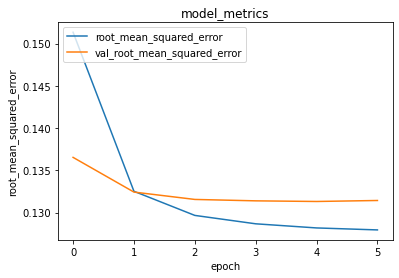

In [32]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'], loc='upper left')
plt.show()